In [1]:
import datacleaner as dtclean
import dataexplore as dtexp
import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_plotly
import seaborn as sns
import plotly.graph_objs as go
import plotly.tools
import matplotlib.pyplot as plt
# Offline mode
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot

# "high resolution"
%config InlineBackend.figure_format = 'retina'
init_notebook_mode(connected=True)

# Visualizando o dataframe

In [2]:
df_274_time_cli = dtclean.get_Dataframes_time(274,'c')
df_274_time_cli.reset_index(inplace=True)
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

iplot(dtexp.getTableDataframe(df_274_time_cli))

# Análise dos Dados

In [3]:
iplot(dtexp.getScatterPlot(df_274_time_cli,title='Clientes/hora (março-maio de 2020)'))

In [5]:
df_new = dtexp.date_features(df_274_time_cli)
trace=go.Table(header=dict(values=list(df_new.columns)),
               cells=dict(values=[df_new.mes,
                                  df_new.diames,
                                  df_new.semana,
                                  df_new.diasemana,
                                  df_new.hora,
                                  df_new.minuto, df_new.y]))

data=[trace]
fig=go.Figure(data=data)
iplot(fig)

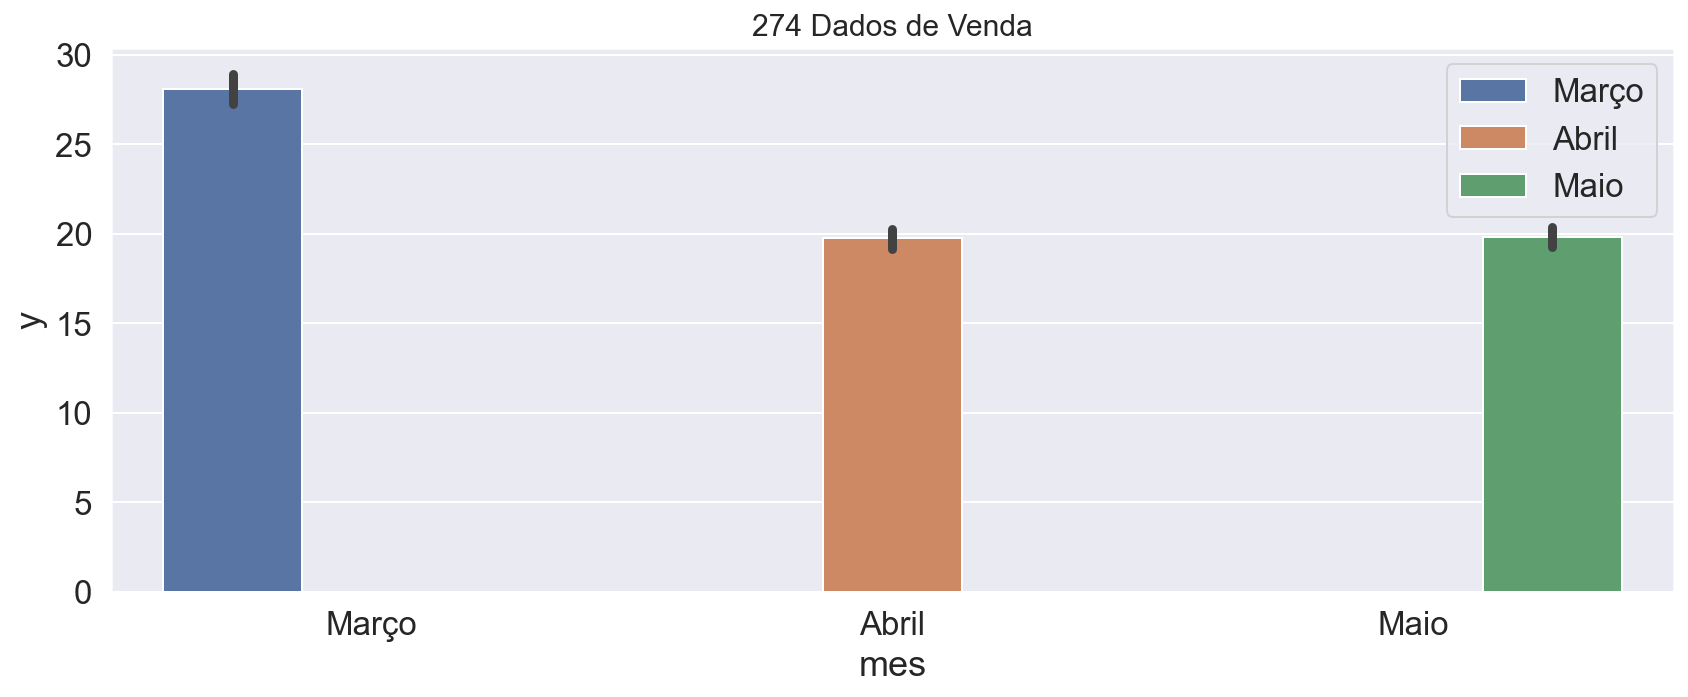

In [6]:
fig, ax = plt.subplots(figsize=(14,5))
plt = dtexp.getDataframeFeatures(df_new,fig, ax)
plt.show()

Text(0.5, 1.0, 'Total Clientes Por Dia da Semana')

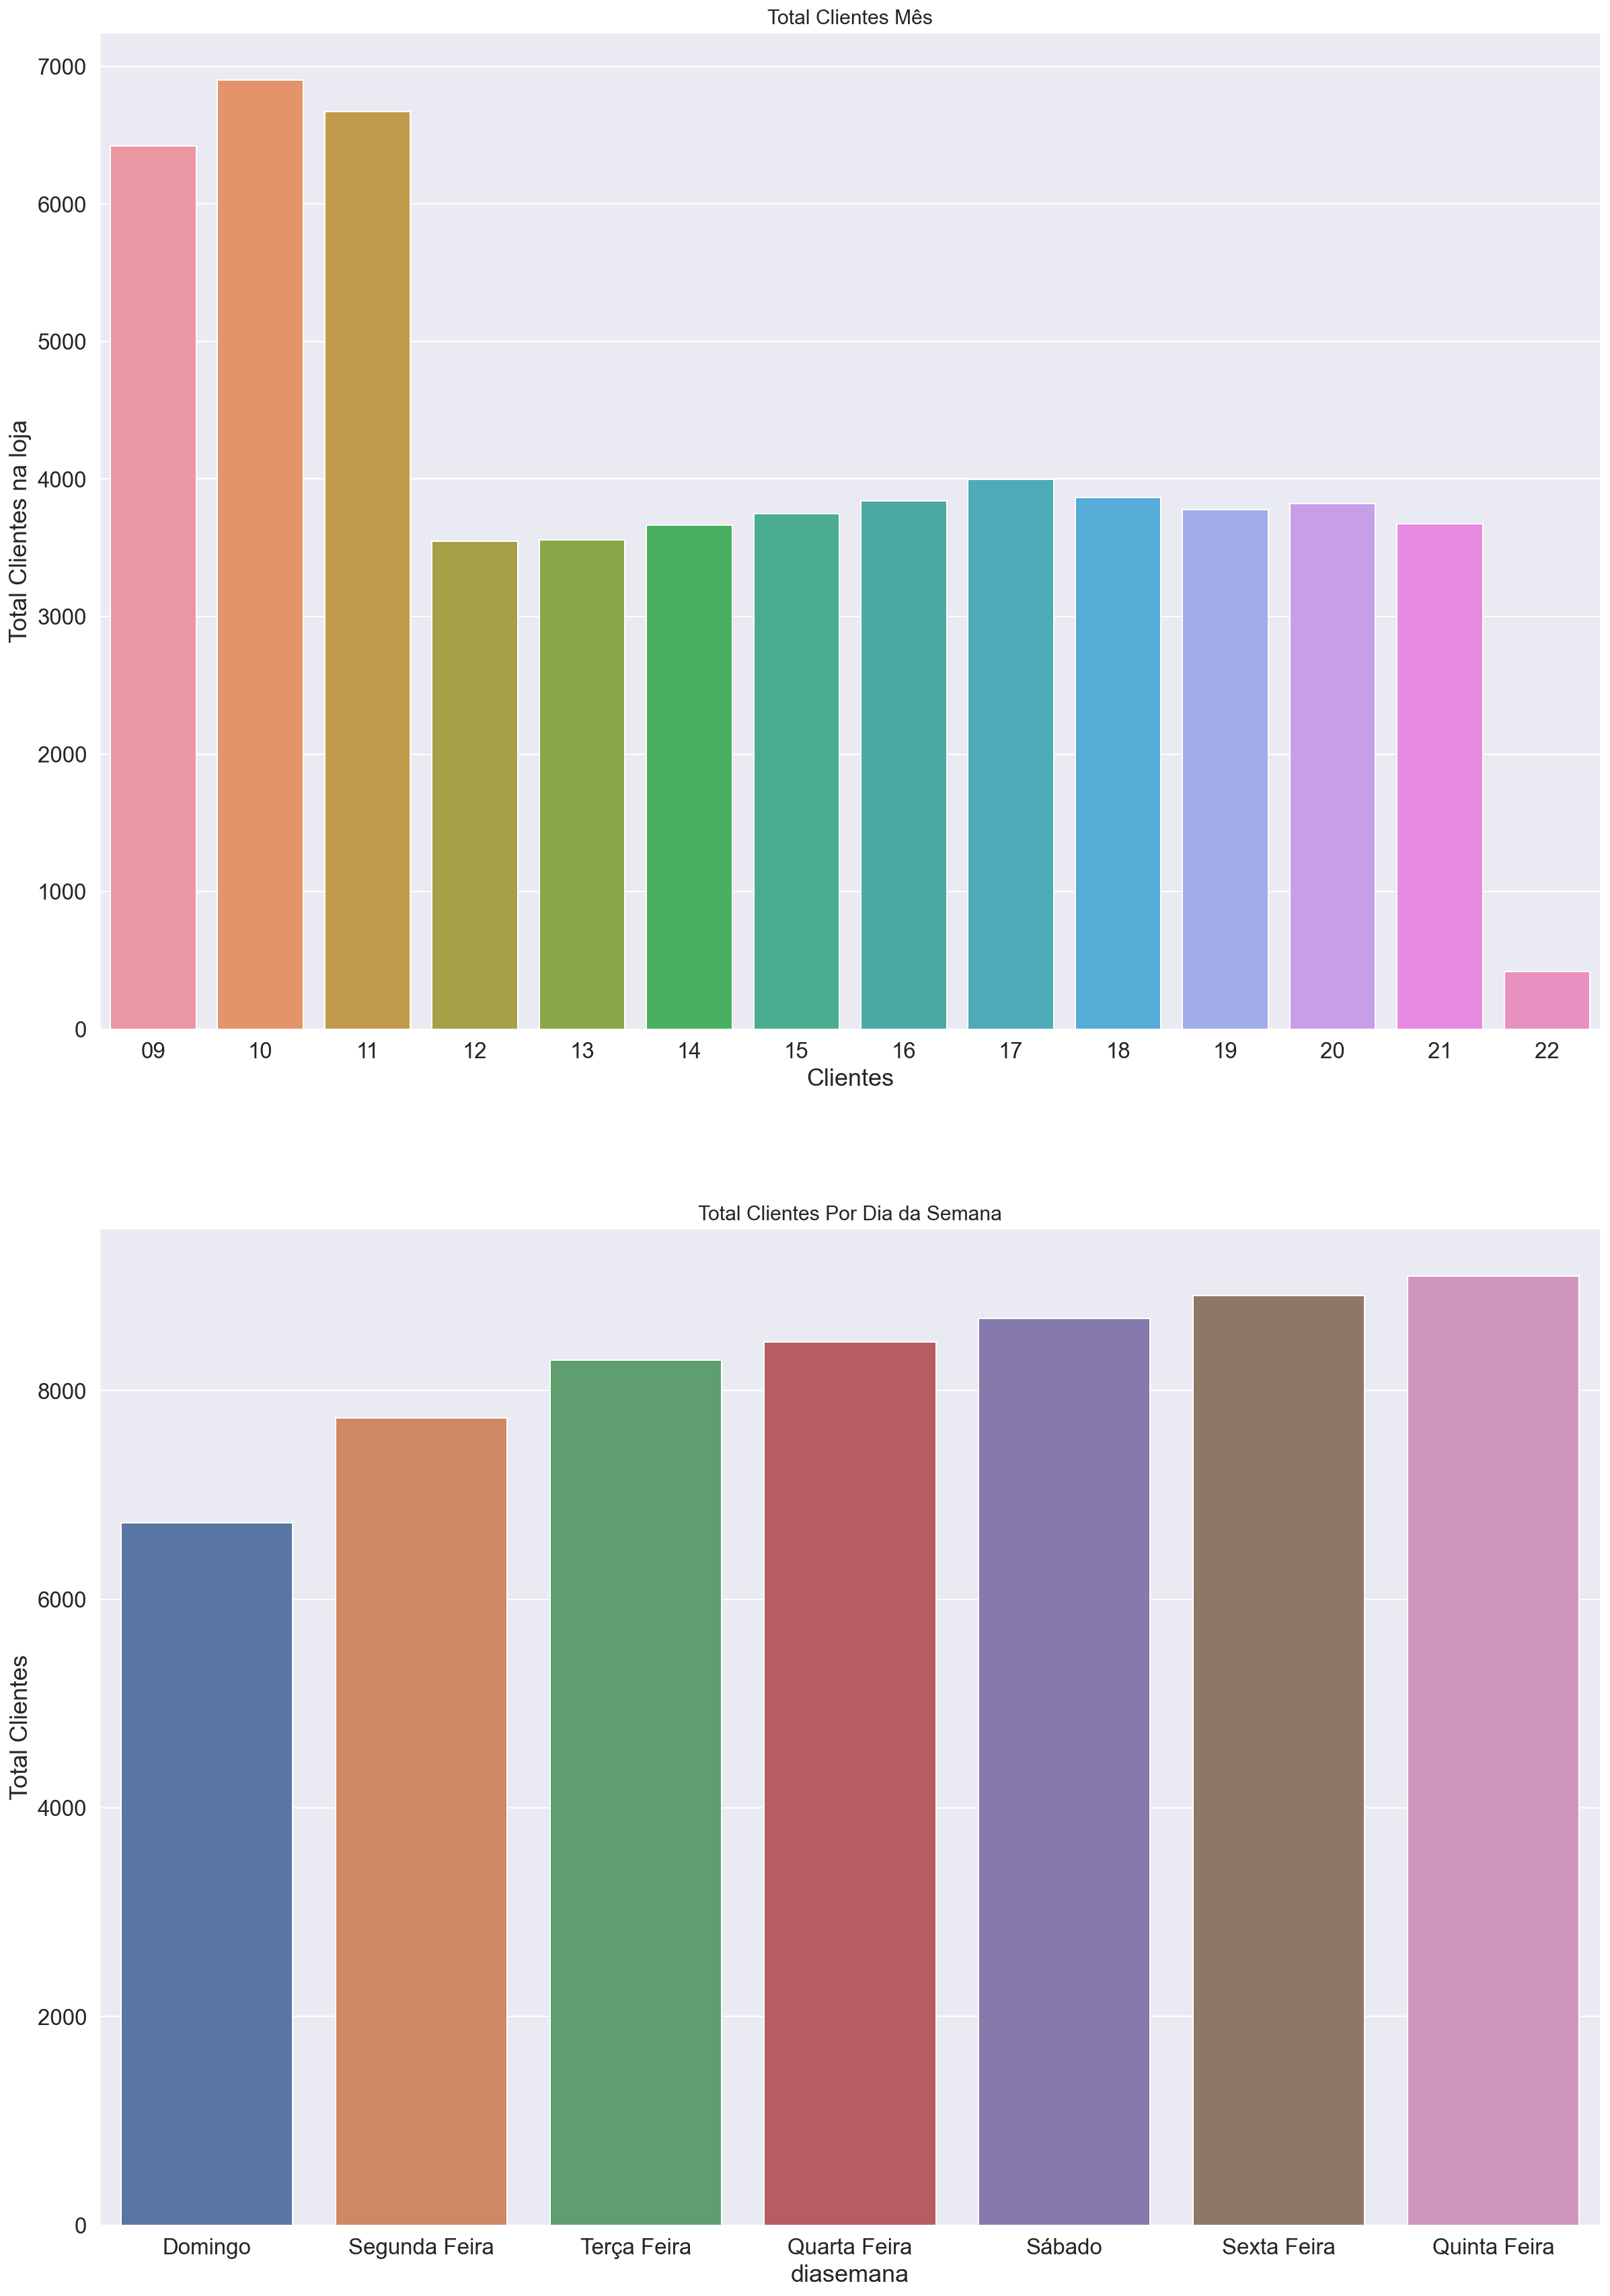

In [7]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(20,30)

mesAgregado = pd.DataFrame(df_new.groupby("semana")["y"].sum()).reset_index().sort_values('y')
sns.barplot(data=mesAgregado,x="semana",y="y",ax=ax1)
ax1.set(xlabel='Clientes', ylabel='Total Clientes na loja')
ax1.set_title("Total Clientes Mês",fontsize=15)

semanaAgregada = pd.DataFrame(df_new.groupby("diasemana")["y"].sum()).reset_index().sort_values('y')
sns.barplot(data=semanaAgregada,x="diasemana",y="y",ax=ax2)
ax2.set(xlabel='diasemana', ylabel='Total Clientes')
ax2.set_title("Total Clientes Por Dia da Semana",fontsize=15)

In [9]:
df_274_cli_treino, df_274_cli_teste = dtexp.configura_dataframe_treino_teste(df_274_time_cli)
df_274_cli_treino['cap'] = 67*2
df_274_cli_teste['cap'] = 67*2
df_274_cli_treino['floor'] = 1.3
df_274_cli_teste['floor'] = 1.3
print('-'*60)
print('Shape dataframe de treino --> {}'.format(df_274_cli_treino.shape))
print('Shape dataframe de teste --> {}'.format(df_274_cli_teste.shape))
print('-'*60)

------------------------------------------------------------
Shape dataframe de treino --> (2344, 4)
Shape dataframe de teste --> (211, 4)
------------------------------------------------------------


<ipython-input-9-ce5da2d9aca9>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-ce5da2d9aca9>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-ce5da2d9aca9>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-ce5da2d9aca

# Visualizando o montante de dados para os datasets de treino e de teste

In [10]:
iplot(dtexp.viewCompareDataframes(df_274_cli_treino,
                                   df_274_cli_teste,
                                   title='Montante de dados de qtd clientes em Treinamento e Teste',
                                    mode='lines',
                                   name1='Treinamento',
                                   name2='Teste'))

In [12]:
prophet = Prophet()
prophet.fit(df_274_cli_treino)
future_vendas = prophet.make_future_dataframe(periods=7, freq='D')
future_vendas['cap'] = 67*2
future_vendas['floor'] = 1
# Removendo valores fora do range de atendimento da loja (22:30 - 05:59)
future_vendas['ds'] = pd.to_datetime(future_vendas['ds'])
future_vendas = future_vendas.set_index(pd.DatetimeIndex(future_vendas['ds']))
future_vendas = future_vendas.between_time('08:00','21:00')

forecast_vendas = prophet.predict(future_vendas)
trace_forecast=go.Table(header=dict(values=list(forecast_vendas[['ds','yhat','yhat_lower','yhat_upper']])),
               cells=dict(values=[forecast_vendas.ds,
                                  forecast_vendas.yhat,
                                  forecast_vendas.yhat_lower,
                                  forecast_vendas.yhat_upper]))

data=[trace_forecast]
fig_forecast=go.Figure(data=data)
iplot(fig_forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


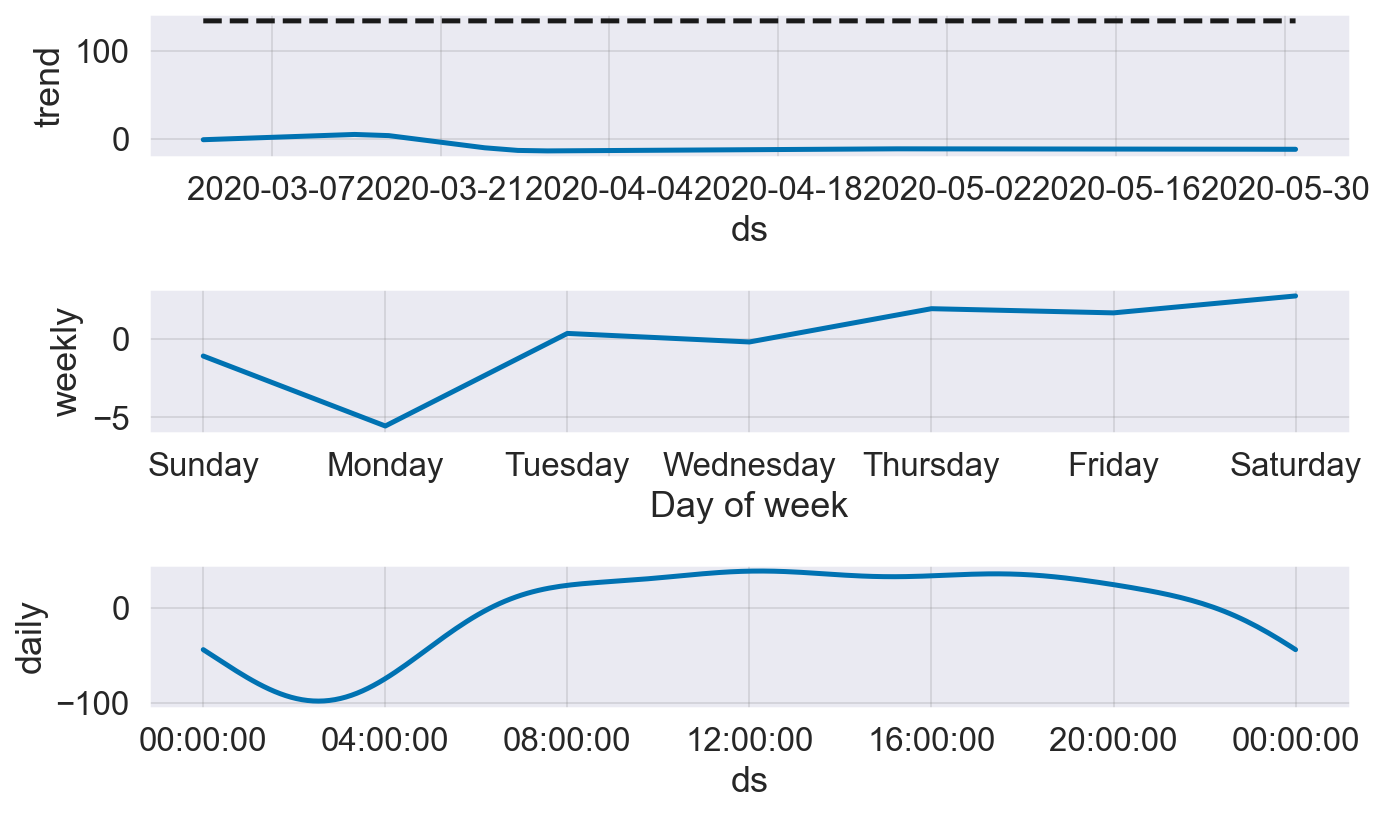

In [13]:
# componentes

fig = prophet.plot_components(forecast_vendas, figsize=(10,6))

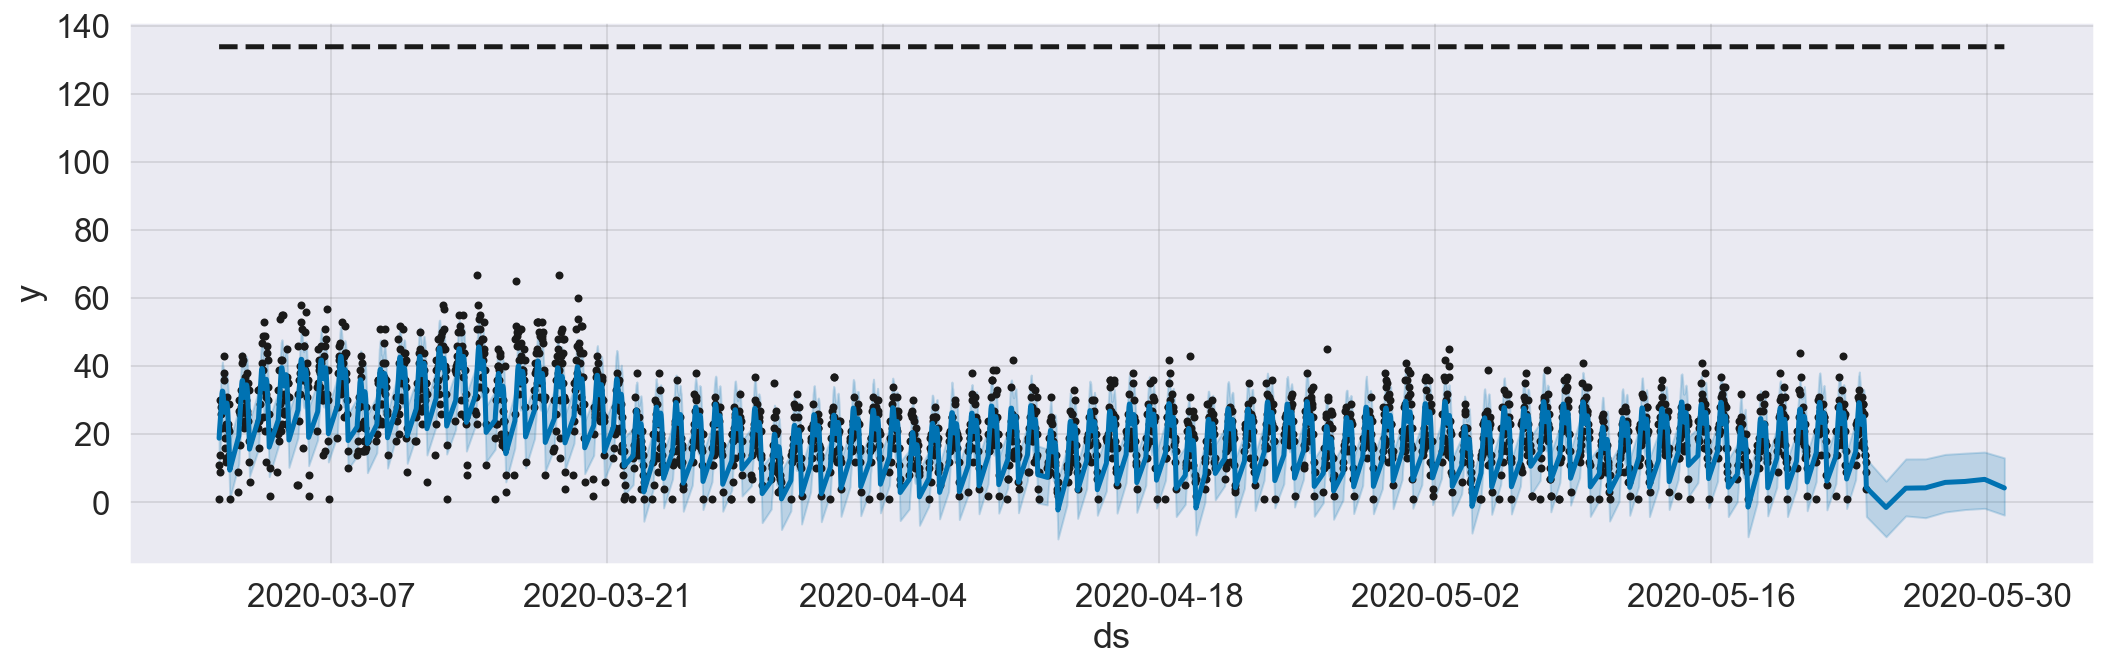

In [14]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = prophet.plot(forecast_vendas,ax=ax)
plt.show()

In [15]:
df_274_cli_teste_forecast = prophet.predict(df_274_cli_teste)
iplot(dtexp.viewDataframeAsTable(df_274_cli_teste_forecast))

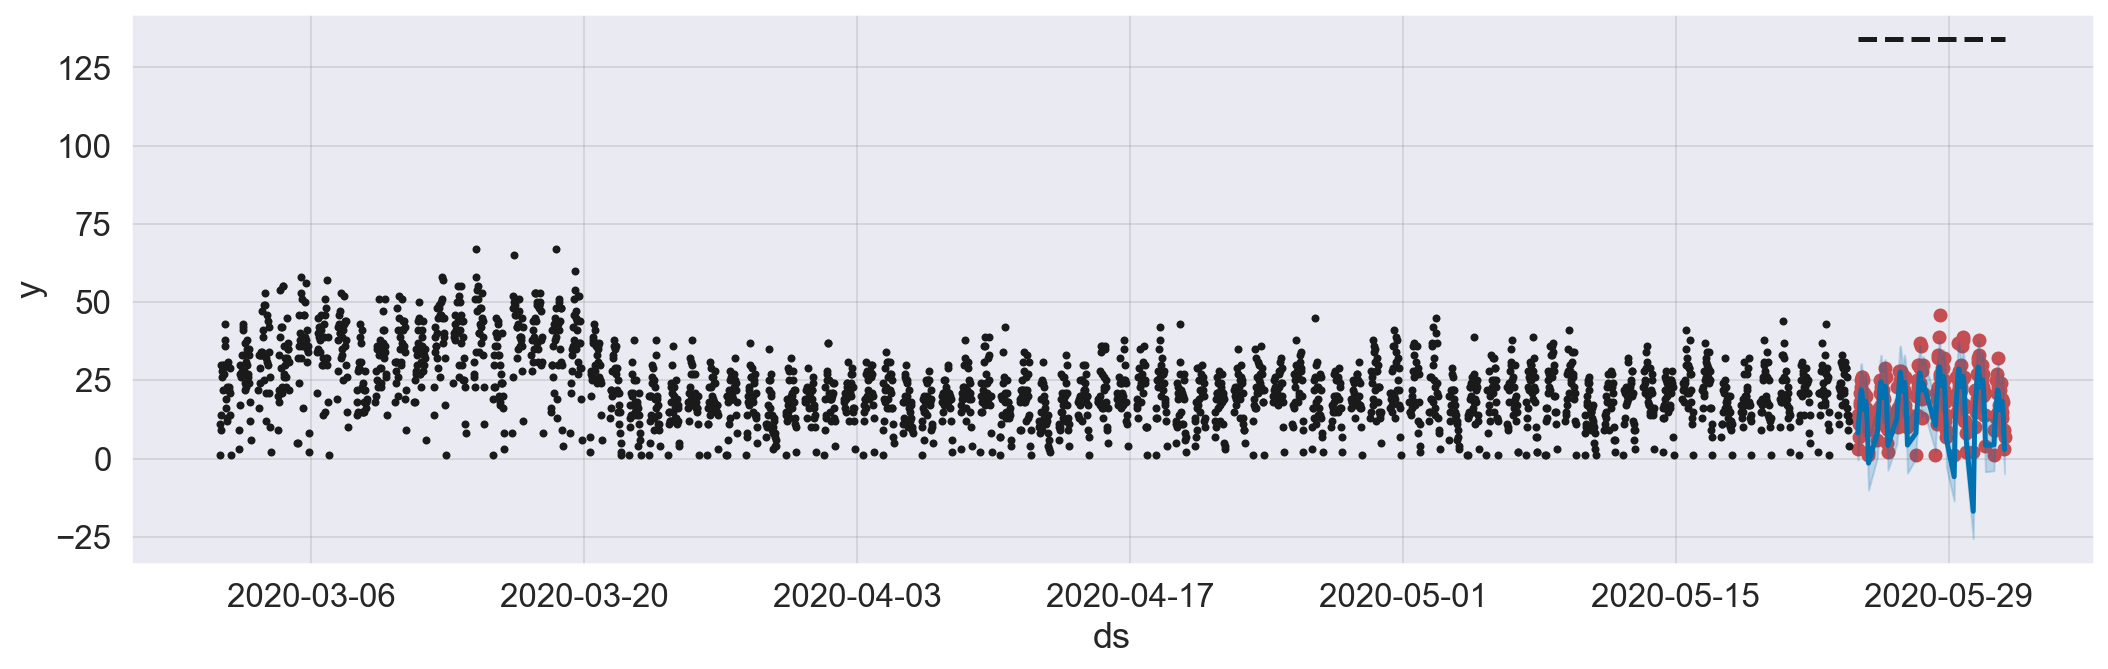

In [16]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_cli_teste.ds,df_274_cli_teste['y'], color='r')
fig = prophet.plot(df_274_cli_teste_forecast,ax=ax)
plt.show()


# Comparação entre as vendas previstas e realizadas


In [17]:
iplot(dtexp.viewCompareDataframes(df_274_cli_teste,
                                   df_274_cli_teste_forecast,
                                   title='Qtd Clientes (previsão) vs Qtd Clientes (real)',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

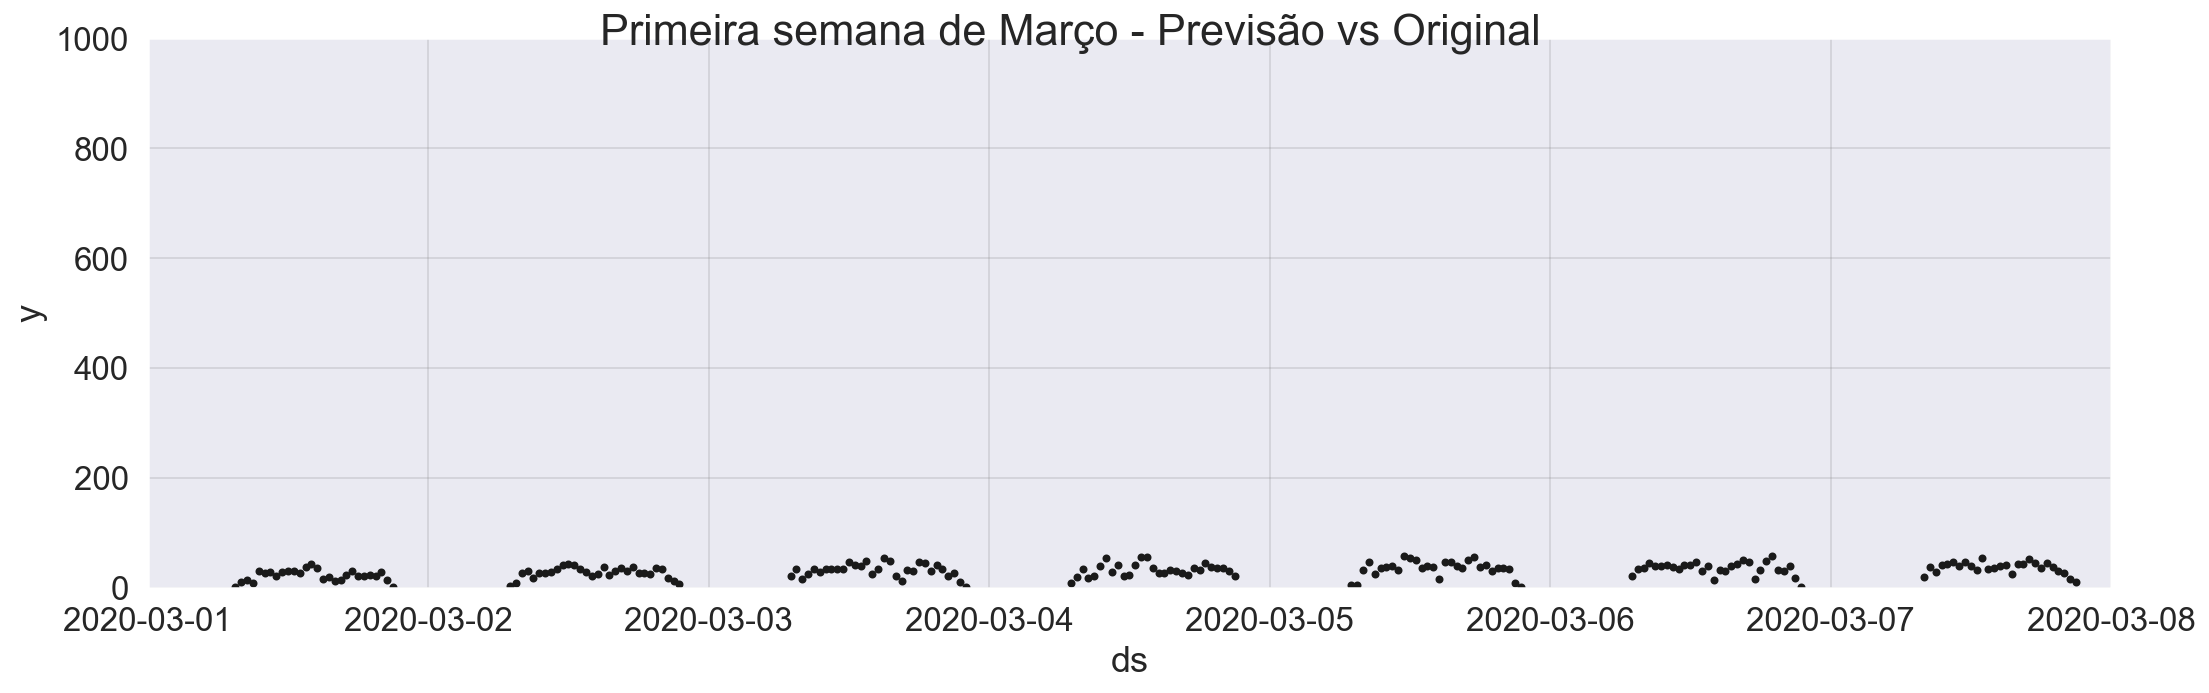

In [18]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_cli_teste.ds, df_274_cli_teste['y'], color='r')
fig = prophet.plot(df_274_cli_teste_forecast, ax=ax)
ax.set_xbound(lower='2020-03-01', upper='2020-03-08')
ax.set_ylim(0, 1000)
plot = plt.suptitle('Primeira semana de Março - Previsão vs Original')

In [19]:
mape_sem_feriados = dtexp.mean_absolute_percentage_error(df_274_cli_teste['y'],df_274_cli_teste_forecast['yhat'])
print("MAPE",round(mape_sem_feriados,4))

MAPE 44.0547


# Definindo o cap e criando novoo modelo com os feriados

In [20]:
# definindo o cap (carrying capacity)
df_274_cli_treino['cap'] = 67*2
df_274_cli_treino['floor'] = 1
df_274_cli_treino.reset_index(drop=True)
feriados = dtclean.get_Holiday()

<ipython-input-20-1bce5ca3195b>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-20-1bce5ca3195b>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
prophet_feriados = Prophet(holidays=feriados)

prophet_feriados.add_country_holidays('BR')
prophet_feriados.fit(df_274_cli_treino)
# Criando as datas futuras previstas pelo prophet
# A frequência especificada em horas (os dados estão em horas)
future_feriados = prophet_feriados.make_future_dataframe(freq='D', periods=8)
# Prevendo os valores
forecast_feriados = prophet_feriados.predict(future_feriados)
# Removendo valores fora do range de atendimento da loja (22:30 - 05:59)
future_feriados['ds'] = pd.to_datetime(future_feriados['ds'])
future_feriados = future_feriados.set_index(pd.DatetimeIndex(future_feriados['ds']))
future_feriados = future_feriados.between_time('08:00','21:00')
# Previsão optimizada dos valores
forecast_feriados = prophet_feriados.predict(future_feriados)
iplot(dtexp.viewDataframeAsTable(forecast_feriados))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


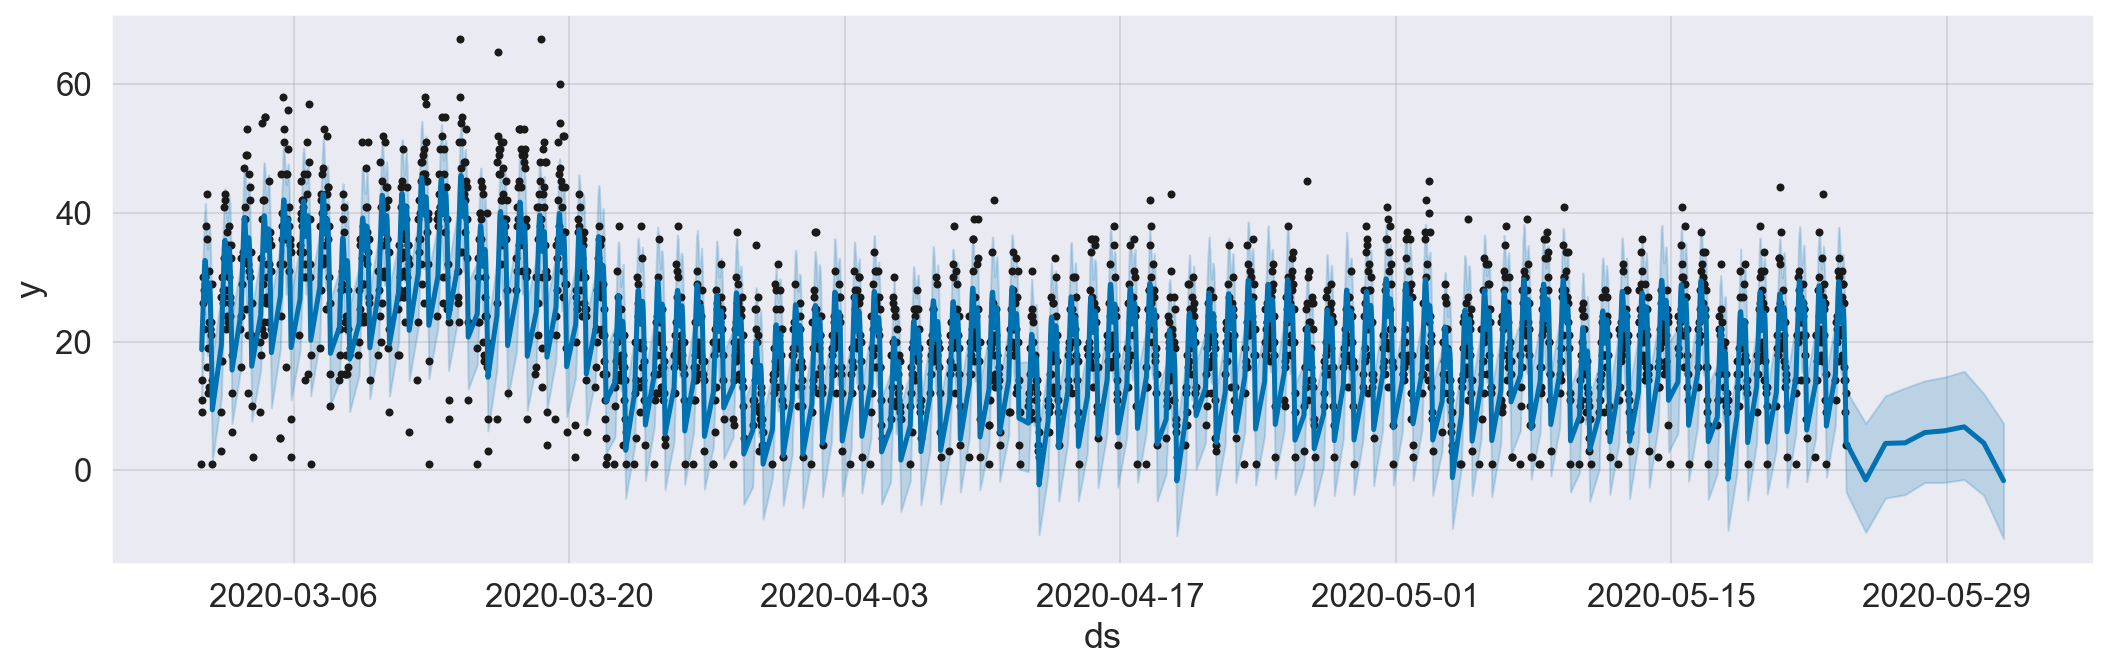

In [22]:
plt,fig_forecast_feriado = dtexp.viewForecastDataframe(forecast_feriados,prophet_feriados,f,ax)
plt.show()

# Visualizando os componentes do modelo

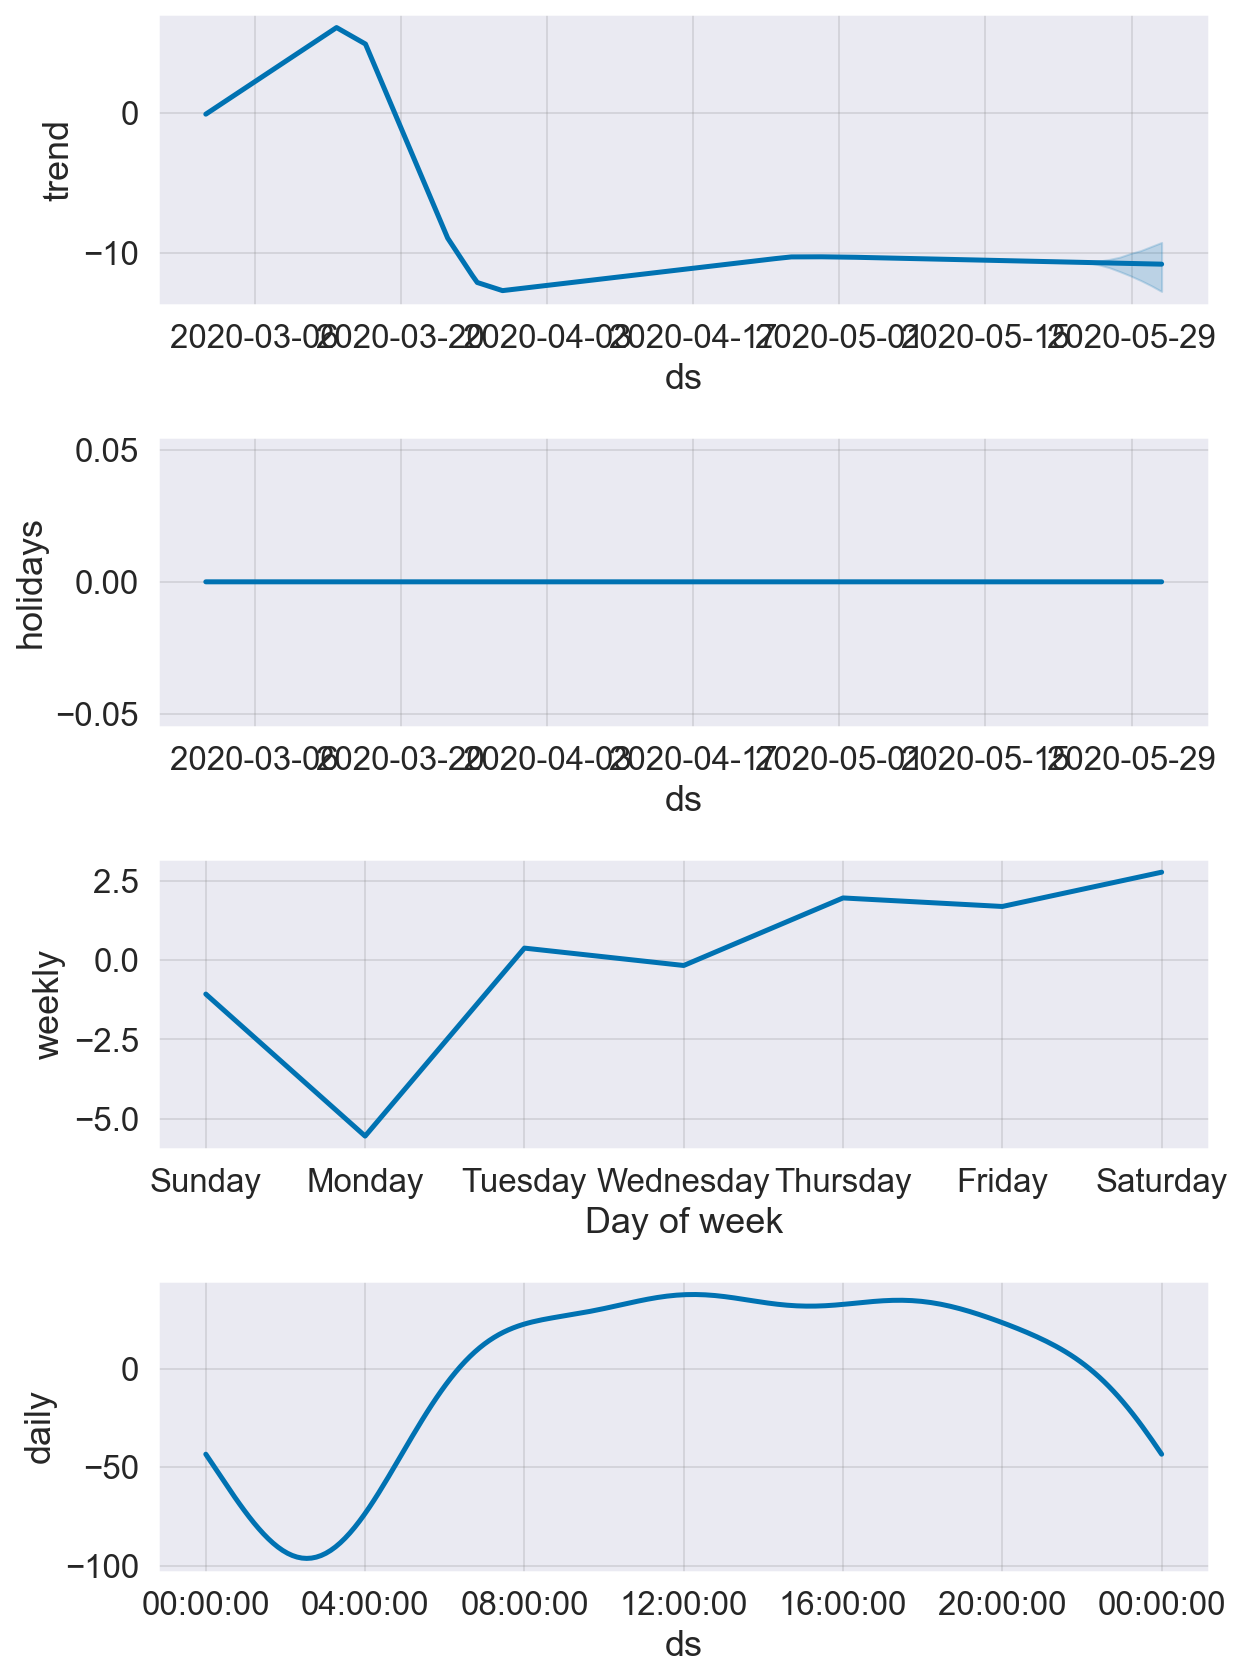

In [23]:
fig_forecast_feriado = prophet_feriados.plot_components(forecast_feriados)

## Visualizar tabela de previsão de teste

In [24]:
forecast_teste_feriados = prophet_feriados.predict(df_274_cli_teste)
iplot(dtexp.viewDataframeAsTable(forecast_teste_feriados))

## Visualizar dataframe de teste previsto e original com feriados

In [25]:
iplot(dtexp.viewCompareDataframes(
    df_274_cli_teste,
    forecast_teste_feriados,
    title='Dados Previsto vs Original última semana de maio/2020',
    mode='lines',
    name1='Original',
    name2='Previsão com feriados',
    is_forecast=True))

In [26]:
mape_com_feriados = dtexp.mean_absolute_percentage_error(df_274_cli_teste.y,forecast_teste_feriados.yhat)
print("MAPE",round(mape_com_feriados,4))

MAPE 43.8688


In [ ]:
dtexp.tuning_model(df_274_cli_treino,df_274_time_cli,periodo=226,frequencia='D')

{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 73.94807612859523
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 73.94807612859523
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 73.94807612859523
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 100, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 697.6810276292119
{'changepoint_prior_scale': 15, 'h

Mean Absolute Percentage Error(MAPE)------------------------------------ 565.7127622816668
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 20, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 565.7127622816668
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 25, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 73.94807612859523
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 25, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 73.94807612859523
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 25, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAP

Mean Absolute Percentage Error(MAPE)------------------------------------ 737.6685227078768
{'changepoint_prior_scale': 20, 'holidays_prior_scale': 15, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 737.6685227078768
{'changepoint_prior_scale': 20, 'holidays_prior_scale': 15, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 737.6685227078768
{'changepoint_prior_scale': 20, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 76.7396497366566
{'changepoint_prior_scale': 20, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)-----

Mean Absolute Percentage Error(MAPE)------------------------------------ 77.52634750001806
{'changepoint_prior_scale': 20, 'holidays_prior_scale': 25, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 737.6685227078768
{'changepoint_prior_scale': 20, 'holidays_prior_scale': 25, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 737.6685227078768
{'changepoint_prior_scale': 20, 'holidays_prior_scale': 25, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 737.6685227078768
{'changepoint_prior_scale': 25, 'holidays_prior_scale': 15, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)----------

Mean Absolute Percentage Error(MAPE)------------------------------------ 79.77151233905258
{'changepoint_prior_scale': 25, 'holidays_prior_scale': 20, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 79.77151233905258
{'changepoint_prior_scale': 25, 'holidays_prior_scale': 20, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 207.8493839762773
{'changepoint_prior_scale': 25, 'holidays_prior_scale': 20, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 207.8493839762773
{'changepoint_prior_scale': 25, 'holidays_prior_scale': 20, 'n_changepoints': 200, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)----------

In [ ]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
                   'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
                   #'seasonality_prior_scale':[15,20,25],
                   'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
                   'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

In [ ]:
import random
strt='2020-03-01 06:00:00'
end='2020-03-08 18:00:00'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=dtclean.get_Holiday(),
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='BR')
    train_model.fit(df_274_cli_treino)
    train_forecast = train_model.make_future_dataframe(periods=226, freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = df_274_time_cli[(df_274_time_cli['ds']>strt) & (df_274_time_cli['ds']<=end)]
    MAPE = dtexp.mean_absolute_percentage_error(Actual['y'],abs(test['yhat']))
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
    model_parameters.to_csv('model_parameters_client_new.csv', sep='\t', encoding='utf-8')

In [48]:
parameters_df = pd.read_csv('model_parameters.csv',sep='\t')
parameters_df = parameters_df.sort_values(by=['MAPE'])
parameters_df = parameters_df.reset_index(drop=True)
parameters_df.drop(['Unnamed: 0'],axis=1,inplace=True)
parameters_df.iloc[0:1]
 trace_df=go.Table(header=dict(values=list(parameters_df[['MAPE','parameters']])),
                            cells=dict(values=[df.MAPE,
                                               df.yhat,
                                               df.yhat_lower,
                                               df.yhat_upper]))
    data=[trace_df]
    fig_df=go.Figure(data=data)


MAPE                                         Parameters
0  69.537453  {'changepoint_prior_scale': 15, 'holidays_prio...

## Treinando o modelo com os melhores parâmetros identificados

+ changepoint_prior_scale= 20
+ holidays_prior_scale = 15
+ n_changepoints = 200
+ seasonality_mode = 'multiplicative'
+ seasonality_prior_scale = 15

In [ ]:
# Configurando e treinando o modelo com feriados e parâmetros otimizados
final_prophet = Prophet(holidays=dtclean.get_Holiday(),
                      changepoint_prior_scale= 20,
                      holidays_prior_scale = 15,
                      n_changepoints = 200,
                      seasonality_mode = 'multiplicative',
                      seasonality_prior_scale = 15,
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_prophet.add_country_holidays(country_name='BR')
final_prophet.fit(df_274_cli_treino)

In [ ]:
future_final = final_prophet.make_future_dataframe(periods=122, freq='D')
forecast_final = final_prophet.predict(future_final)
iplot(dtexp.viewDataframeAsTable(forecast_final))

In [ ]:
# Plot the components of the model
fig = final_prophet.plot_components(forecast_final)

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_prophet.plot(forecast_final,ax=ax)
plt.show()

In [ ]:
df_teste_final= final_prophet.predict(df_274_cli_teste)
iplot(dtexp.viewDataframeAsTable(df_teste_final))

In [ ]:
iplot(dtexp.viewCompareDataframes(df_274_cli_teste,
                                   df_teste_final,
                                   title='Qtd Clientes (previsão) vs Qtd Clientes (real)',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

In [ ]:
mape_final = dtexp.mean_absolute_percentage_error(df_274_cli_teste['y'],df_teste_final['yhat'])
print("MAPE",round(mape_final,4))
